Problem: we need to train a classifier to recognize the subject of articles. We will scrape a dataset from Wikipedia to train and test a Naive Bayes classifier.

Requirements: fetch the contents of the Wikipedia pages listed below. Use Beautiful Soup to fetch the contents of the <p> tags on the page. Store each paragraph as a string in a list. Store another list of labels for each sample of data. The label of each sample should be the subject of the page it was extracted from (so 5 total classes). You should have at least 500 instances of labeled data. You may need to use additional Wikipedia pages closely related to the main articles in order to expand the size of your dataset.

The Wikipedia pages to scrape are:

Chemistry
Physics
Medicine
Philosophy
Mathematics

After you have finished scraping your dataset, preprocess the data using standard techniques (e.g. convert to lower case, remove stopwords, remove citations, remove html tags, etc.). Then split the data and labels into train and test sets using an 80/20 train-test split. Finally, you will need to vectorize the data using an appropriate technique (e.g. CountVectorizer from SKLearn).

After you have completely processed your data, train a Naive Bayes model from SKLearn. using the train set. Test your model on the test set. Try to achieve an accuracy of 0.9+. You may need to tune the hyper-parameters of your model or add additional pre-processing steps to improve the accuracy of the model.

You should use a time.sleep function call in your program to avoid making excessive requests to Wikipedia.



After you are finished with tuning the model, print its confusion matrix and compute its accuracy on the test set.

Submit your solution as an .ipynb or .py file.

In [19]:
import requests
import re
import time
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [20]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
wikipedia_pages = {
    "Chemistry": [
        "https://en.wikipedia.org/wiki/Chemistry",
        "https://en.wikipedia.org/wiki/Organic_chemistry",
        "https://en.wikipedia.org/wiki/Inorganic_chemistry"
    ],
    "Physics": [
        "https://en.wikipedia.org/wiki/Physics",
        "https://en.wikipedia.org/wiki/Quantum_mechanics",
        "https://en.wikipedia.org/wiki/Classical_mechanics"
    ],
    "Medicine": [
        "https://en.wikipedia.org/wiki/Medicine",
        "https://en.wikipedia.org/wiki/Surgery",
        "https://en.wikipedia.org/wiki/Pediatrics"
    ],
    "Philosophy": [
        "https://en.wikipedia.org/wiki/Philosophy",
        "https://en.wikipedia.org/wiki/Ethics",
        "https://en.wikipedia.org/wiki/Metaphysics"
    ],
    "Mathematics": [
        "https://en.wikipedia.org/wiki/Mathematics",
        "https://en.wikipedia.org/wiki/Algebra",
        "https://en.wikipedia.org/wiki/Calculus"
    ]
}

In [30]:
# Preprocessing function with stemming and improved cleaning
def preprocess_text(text):
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove citations
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    tokens = word_tokenize(text)  # Tokenize
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stopwords.words('english') and len(word) > 2]
    return ' '.join(filtered_tokens)


In [31]:
# Function to fetch and parse paragraphs from a Wikipedia page
def fetch_paragraphs(url):
    time.sleep(2)  # Sleep to avoid excessive requests
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        paragraphs = [p.get_text() for p in soup.find_all('p') if len(p.get_text().strip()) > 50]
        return [preprocess_text(paragraph) for paragraph in paragraphs]
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return []

# Fetch data and labels
texts, labels = [], []

for subject, urls in wikipedia_pages.items():
    for url in urls:
        print(f"Fetching and preprocessing data for {subject} from {url}...")
        paragraphs = fetch_paragraphs(url)
        texts.extend(paragraphs)
        labels.extend([subject] * len(paragraphs))


Fetching and preprocessing data for Chemistry from https://en.wikipedia.org/wiki/Chemistry...
Fetching and preprocessing data for Chemistry from https://en.wikipedia.org/wiki/Organic_chemistry...
Fetching and preprocessing data for Chemistry from https://en.wikipedia.org/wiki/Inorganic_chemistry...
Fetching and preprocessing data for Physics from https://en.wikipedia.org/wiki/Physics...
Fetching and preprocessing data for Physics from https://en.wikipedia.org/wiki/Quantum_mechanics...
Fetching and preprocessing data for Physics from https://en.wikipedia.org/wiki/Classical_mechanics...
Fetching and preprocessing data for Medicine from https://en.wikipedia.org/wiki/Medicine...
Fetching and preprocessing data for Medicine from https://en.wikipedia.org/wiki/Surgery...
Fetching and preprocessing data for Medicine from https://en.wikipedia.org/wiki/Pediatrics...
Fetching and preprocessing data for Philosophy from https://en.wikipedia.org/wiki/Philosophy...
Fetching and preprocessing data for

In [32]:
# Create DataFrame
data = pd.DataFrame({'text': texts, 'label': labels})

# Check sample count
if len(data) < 500:
    print(f"Warning: Less than 500 samples collected ({len(data)} samples).")
else:
    print(f"✅ Collected {len(data)} samples.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

# Vectorization with optimized parameters
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 4),
    max_df=0.75,
    min_df=2,
    sublinear_tf=True
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


✅ Collected 970 samples.


In [33]:
# Enhanced hyperparameter tuning with GridSearchCV
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5],
}
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5]},
             scoring='accuracy')

In [34]:
# Best model and evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best alpha: 0.5
Test Accuracy: 0.9485
Classification Report:
              precision    recall  f1-score   support

   Chemistry       0.94      0.94      0.94        33
 Mathematics       0.93      0.95      0.94        42
    Medicine       0.97      0.88      0.92        32
  Philosophy       0.93      1.00      0.97        42
     Physics       0.98      0.96      0.97        45

    accuracy                           0.95       194
   macro avg       0.95      0.94      0.95       194
weighted avg       0.95      0.95      0.95       194



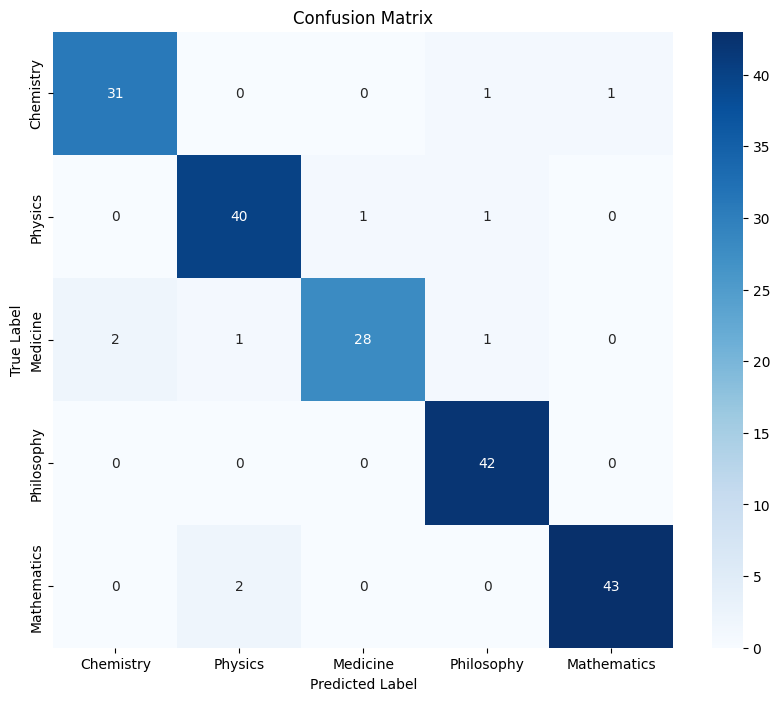

In [35]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=wikipedia_pages.keys(), yticklabels=wikipedia_pages.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
# Check if target accuracy is achieved
if accuracy >= 0.9:
    print("Target accuracy of 0.9+ achieved!")
else:
    print("Target accuracy not reached. Consider further preprocessing or model adjustments.")


Target accuracy of 0.9+ achieved!
